#**Assignment #6**

*   **Mohammad Issa**
*   **ID:1210047**



#Step 1: Import Necessary Libraries

#First, import the necessary libraries:



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob


#Step 2: Load and Combine Data & Data Cleaning
Clean the combined DataFrame by handling missing values, duplicates, and inconsistencies:


#Since We have multiple CSV files for each year, we will combine them into one DataFrame:



In [9]:

# File paths
file_paths = [
    r"C:\Users\HP\Downloads\happiness score\happiness score\2015.csv",
    r"C:\Users\HP\Downloads\happiness score\happiness score\2016.csv",
    r"C:\Users\HP\Downloads\happiness score\happiness score\2017.csv",
    r"C:\Users\HP\Downloads\happiness score\happiness score\2018.csv",
    r"C:\Users\HP\Downloads\happiness score\happiness score\2019.csv"
]

# List to store DataFrames
data_frames = []

# Define columns to drop
columns_to_drop = [
    'Standard Error', 'Economy (GDP per Capita)', 'Family', 
    'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)', 
    'Generosity', 'Dystopia Residual', 'Lower Confidence Interval', 
    'Upper Confidence Interval', 'Whisker.high', 'Whisker.low',
    'Economy..GDP.per.Capita.', 'Health..Life.Expectancy.', 
    'Trust..Government.Corruption.', 'Dystopia.Residual', 
    'Country or region', 'GDP per capita', 'Social support', 
    'Healthy life expectancy', 'Freedom to make life choices', 
    'Perceptions of corruption'
]

# Function to clean each DataFrame
def clean_dataframe(df, year):
    # Standardize column names
    df.rename(columns={
        'Country or region': 'Country',
        'Score': 'Happiness Score',
        'Happiness.Rank': 'Happiness Rank',
        'Happiness.Score': 'Happiness Score',
        'Overall rank': 'Happiness Rank',
    }, inplace=True)
    
    # Add Year column
    df['Year'] = year
    
    # Drop unnecessary columns
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    return df

# Read and clean each file
for file, year in zip(file_paths, range(2015, 2020)):
    df = pd.read_csv(file)
    df = clean_dataframe(df, year)
    data_frames.append(df)

# Combine DataFrames
combined_df = pd.concat(data_frames, ignore_index=True)

# Impute missing 'Region' values using data from 2015 and 2016
region_map = combined_df[combined_df['Year'] <= 2016].set_index('Country')['Region'].to_dict()
combined_df['Region'] = combined_df['Country'].map(region_map).fillna('Unknown')

# Data Cleaning
combined_df.drop_duplicates(inplace=True)
combined_df.dropna(subset=['Happiness Score'], inplace=True)
combined_df['Year'] = combined_df['Year'].astype(int)

# Fill missing regions based on country
def fill_region_by_country(group):
    v = group.dropna().iloc[0]
    return group.fillna(v)

combined_df['Region'] = combined_df['Region'].groupby(combined_df['Country']).transform(fill_region_by_country)

# Check combined DataFrame info and content
print(combined_df.info())
print(combined_df.head())

# Verify that all years are included
print("Years included in the dataset:", combined_df['Year'].unique())
print("Counts of entries per year:")
print(combined_df['Year'].value_counts())

# Check for missing values in Region and Happiness Score
missing_data = combined_df[['Region', 'Happiness Score']].isnull().sum()
print(missing_data)

print(combined_df.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          782 non-null    object 
 1   Region           782 non-null    object 
 2   Happiness Rank   782 non-null    int64  
 3   Happiness Score  782 non-null    float64
 4   Year             782 non-null    int32  
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 27.6+ KB
None
       Country          Region  Happiness Rank  Happiness Score  Year
0  Switzerland  Western Europe               1            7.587  2015
1      Iceland  Western Europe               2            7.561  2015
2      Denmark  Western Europe               3            7.527  2015
3       Norway  Western Europe               4            7.522  2015
4       Canada   North America               5            7.427  2015
Years included in the dataset: [2015 2016 2017 2018 2019]
Counts of entries 

#Step 3: Answer Questions with Visualizations
1. Which region has the highest and lowest happiness score?

Region with the highest average happiness score: Australia and New Zealand (7.294600004959106)
Region with the lowest average happiness score: Sub-Saharan Africa (4.188482052181929)


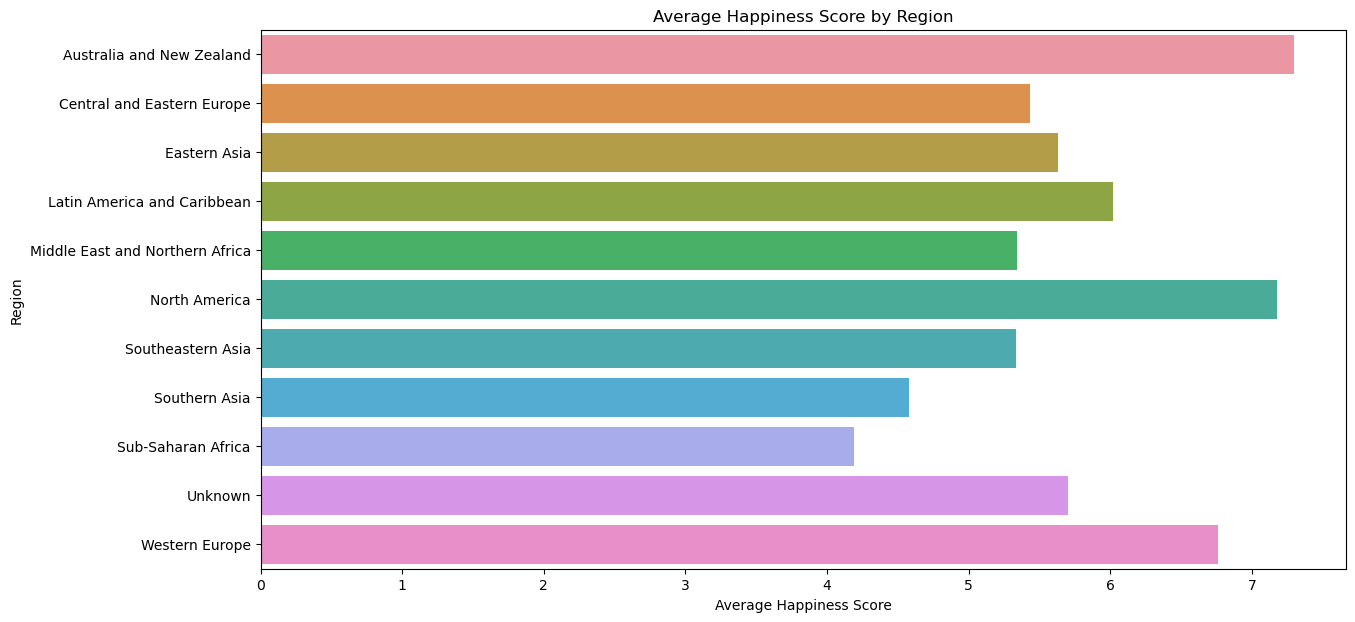

In [10]:


# Recalculate region_happiness
region_happiness = combined_df.groupby('Region')['Happiness Score'].mean().reset_index()

# Find region with highest and lowest happiness score
max_region = region_happiness.loc[region_happiness['Happiness Score'].idxmax()]
min_region = region_happiness.loc[region_happiness['Happiness Score'].idxmin()]

print(f"Region with the highest average happiness score: {max_region['Region']} ({max_region['Happiness Score']})")
print(f"Region with the lowest average happiness score: {min_region['Region']} ({min_region['Happiness Score']})")

# Plotting
plt.figure(figsize=(14, 7))
sns.barplot(data=region_happiness, x='Happiness Score', y='Region')
plt.title('Average Happiness Score by Region')
plt.xlabel('Average Happiness Score')
plt.ylabel('Region')
plt.show()


2. Which regions have countries with extreme (outliers) happiness scores?



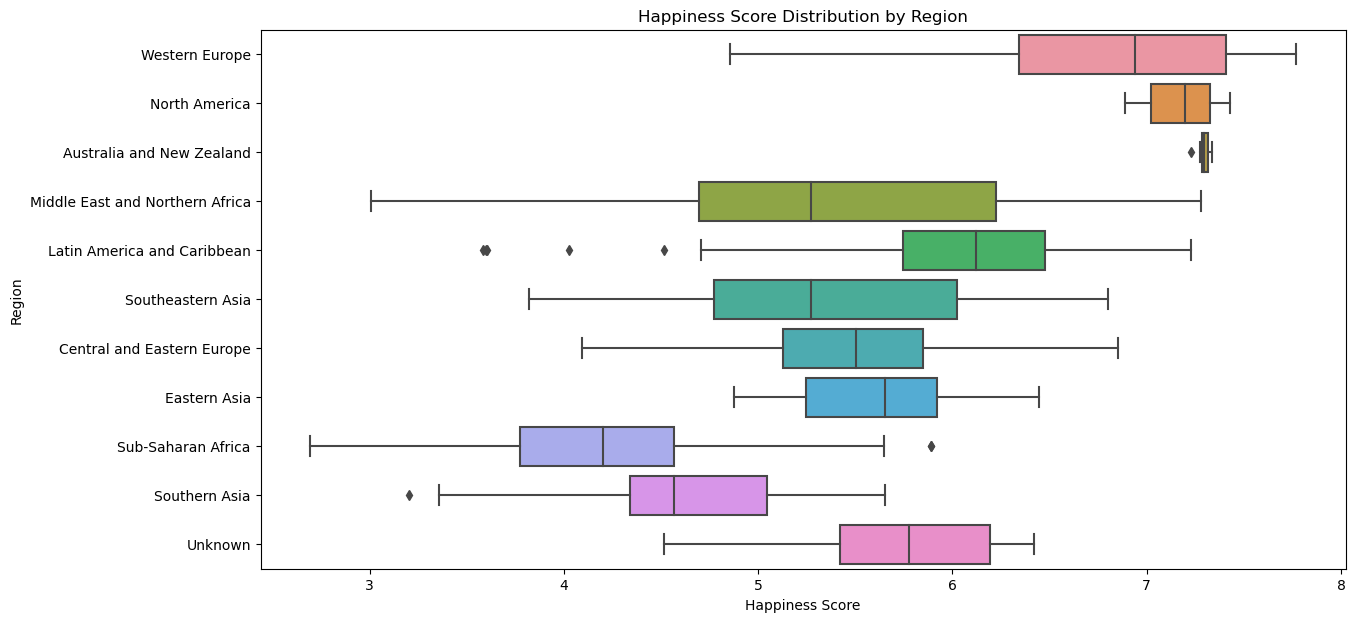

Outliers detected:
       Country                       Region  Happiness Rank  Happiness Score  \
0    Australia    Australia and New Zealand              11            7.228   
1        Haiti  Latin America and Caribbean             119            4.518   
2        Haiti  Latin America and Caribbean             136            4.028   
3        Haiti  Latin America and Caribbean             145            3.603   
4        Haiti  Latin America and Caribbean             148            3.582   
5        Haiti  Latin America and Caribbean             147            3.597   
6  Afghanistan                Southern Asia             154            3.203   
7    Mauritius           Sub-Saharan Africa              55            5.891   
8    Mauritius           Sub-Saharan Africa              57            5.888   

   Year  
0  2019  
1  2015  
2  2016  
3  2017  
4  2018  
5  2019  
6  2019  
7  2018  
8  2019  
Regions with countries having extreme (outliers) happiness scores:
Australia and

In [14]:
plt.figure(figsize=(14, 7))
sns.boxplot(data=combined_df, x='Happiness Score', y='Region')
plt.title('Happiness Score Distribution by Region')
plt.xlabel('Happiness Score')
plt.ylabel('Region')
plt.show()

# Identifying outliers within each region
def detect_outliers(group):
    q1 = group['Happiness Score'].quantile(0.25)
    q3 = group['Happiness Score'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return group[(group['Happiness Score'] < lower_bound) | (group['Happiness Score'] > upper_bound)]

outliers = combined_df.groupby('Region').apply(detect_outliers).reset_index(drop=True)

# Print outliers for debugging
print("Outliers detected:")
print(outliers)

# Identify regions with outliers
regions_with_outliers = outliers['Region'].unique()

print("Regions with countries having extreme (outliers) happiness scores:")
for region in regions_with_outliers:
    print(region)

3. Show how the global happiness score changes over time


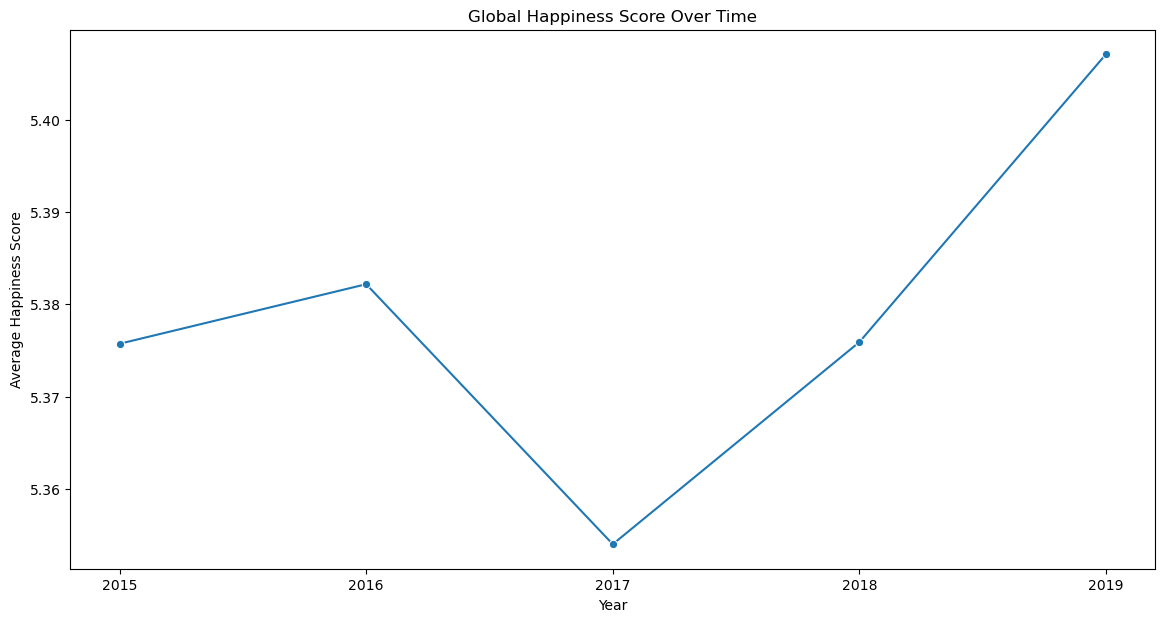

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          782 non-null    object 
 1   Region           782 non-null    object 
 2   Happiness Rank   782 non-null    int64  
 3   Happiness Score  782 non-null    float64
 4   Year             782 non-null    int32  
dtypes: float64(1), int32(1), int64(1), object(2)
memory usage: 27.6+ KB


In [15]:
# Global happiness score change over time
global_happiness = combined_df.groupby('Year')['Happiness Score'].mean().reset_index()

# Ensure the 'Year' column is of integer type
global_happiness['Year'] = global_happiness['Year'].astype(int)

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(data=global_happiness, x='Year', y='Happiness Score', marker='o')
plt.title('Global Happiness Score Over Time')
plt.xlabel('Year')
plt.ylabel('Average Happiness Score')
plt.xticks(global_happiness['Year'])  # Ensure that the x-ticks are the years
plt.show()
combined_df.info()

4. How does the Happiness Score change by Region?


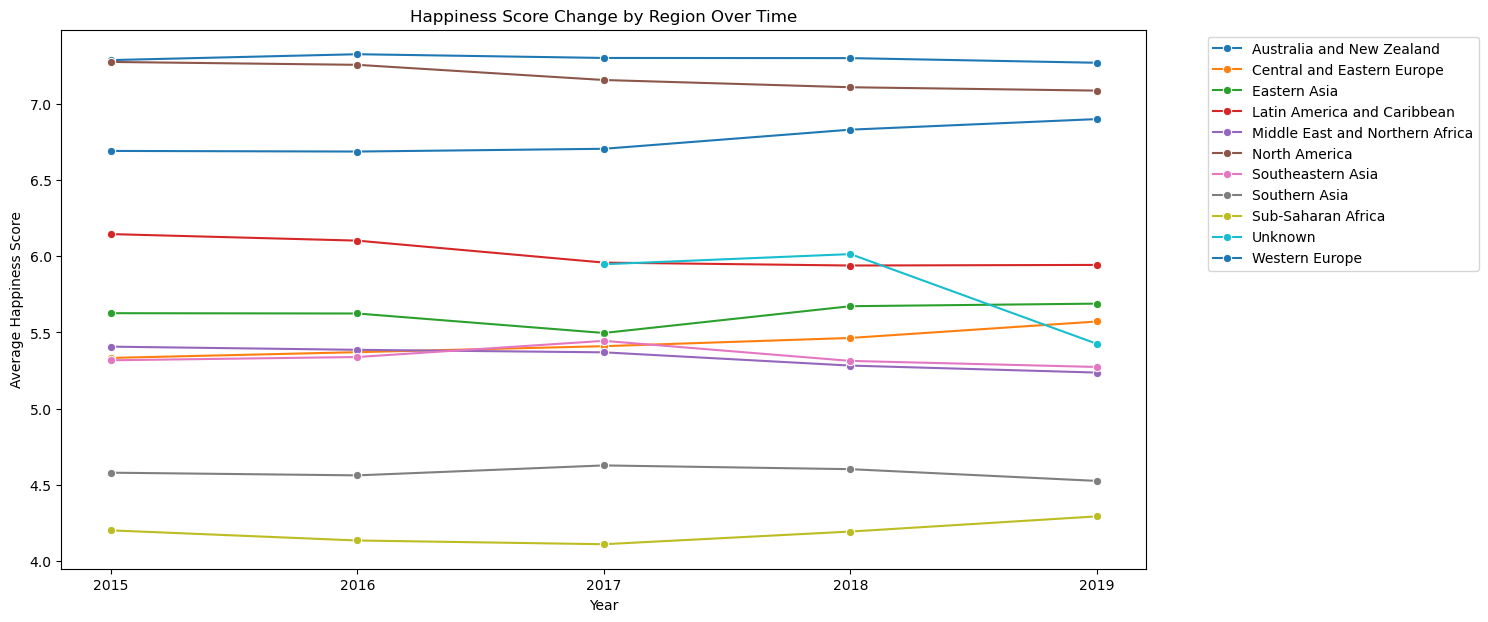

In [16]:
# Calculate average happiness score by region and year
region_happiness = combined_df.groupby(['Region', 'Year'])['Happiness Score'].mean().reset_index()

# Plotting
plt.figure(figsize=(14, 7))

# Loop through each region to plot its happiness score over time
for region in region_happiness['Region'].unique():
    region_data = region_happiness[region_happiness['Region'] == region]
    sns.lineplot(data=region_data, x='Year', y='Happiness Score', marker='o', label=region)

plt.title('Happiness Score Change by Region Over Time')
plt.xlabel('Year')
plt.ylabel('Average Happiness Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position
plt.xticks(region_happiness['Year'].unique())  # Ensure that the x-ticks are the years
plt.show()


5. Predicting Global Happiness Score for the Next Two Years: I made a clear statments to clear the way of solution



Mean Happiness Scores by Year:
Year
2015    5.375734
2016    5.382185
2017    5.354019
2018    5.375917
2019    5.407096
Name: Happiness Score, dtype: float64

Year-on-Year Differences:
Year
2016    0.006451
2017   -0.028165
2018    0.021897
2019    0.031179
Name: Happiness Score, dtype: float64

Average Year-on-Year Difference:
0.007840494157741018

Predicted Happiness Scores for 2020 and 2021:
      Happiness Score
2020         5.414937
2021         5.422777

Combined Data with Predictions:
2015    5.375734
2016    5.382185
2017    5.354019
2018    5.375917
2019    5.407096
2020    5.414937
2021    5.422777
Name: Happiness Score, dtype: float64


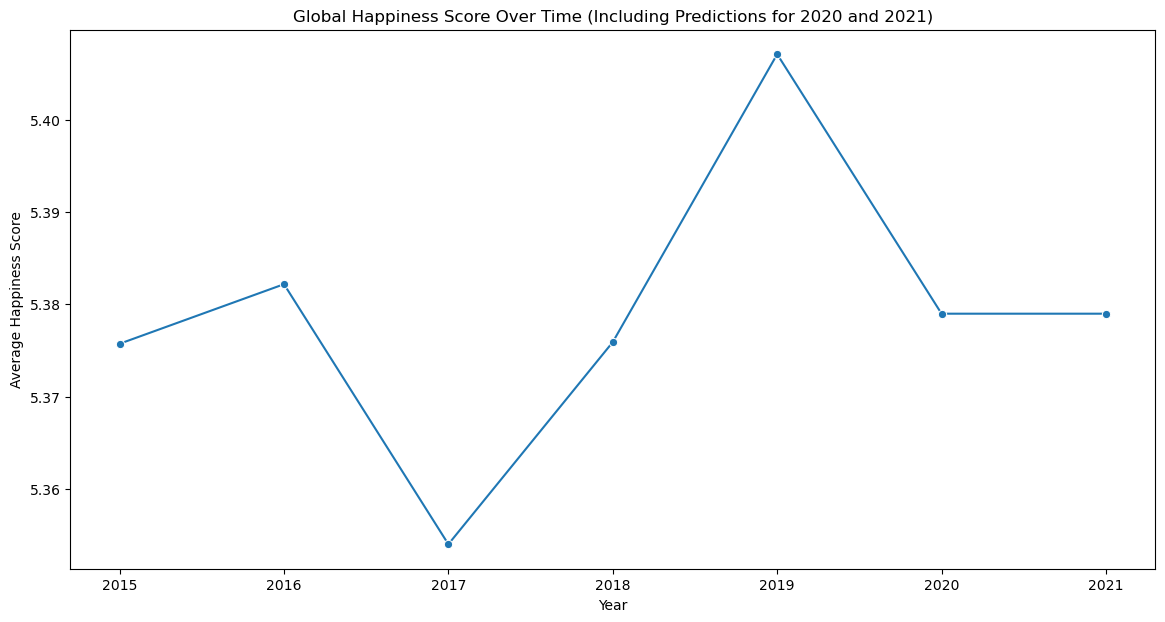

In [33]:


# Calculate the mean happiness score for each year
mean_scores_by_year = combined_df.groupby('Year')['Happiness Score'].mean()

# Calculate the year-on-year difference
year_on_year_diff = mean_scores_by_year.diff().dropna()

# Calculate the average year-on-year difference
average_diff = year_on_year_diff.mean()

# Predict the happiness score for the next two years
last_year = mean_scores_by_year.index[-1]
predictions = {}
for year in range(last_year + 1, last_year + 3):
    next_score = mean_scores_by_year.iloc[-1] + average_diff * (year - last_year)
    predictions[year] = next_score

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame.from_dict(predictions, orient='index', columns=['Happiness Score'])

# Concatenate the original mean scores with the predictions
combined_df_with_predictions = pd.concat([mean_scores_by_year, predictions_df['Happiness Score']])

# Print results
print("Mean Happiness Scores by Year:")
print(mean_scores_by_year)
print("\nYear-on-Year Differences:")
print(year_on_year_diff)
print("\nAverage Year-on-Year Difference:")
print(average_diff)
print("\nPredicted Happiness Scores for 2020 and 2021:")
print(predictions_df)
print("\nCombined Data with Predictions:")
print(combined_df_with_predictions)

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(data=global_happiness, x='Year', y='Happiness Score', marker='o')
plt.title('Global Happiness Score Over Time (Including Predictions for 2020 and 2021)')
plt.xlabel('Year')
plt.ylabel('Average Happiness Score')
plt.xticks(global_happiness['Year'])  # Ensure that the x-ticks are the years
plt.show()
